# Introduction

This notebook implement a Deep Recurrent Q-learning Network for automated stock trading as presented in:  
- L. Chen and Q. Gao, "Application of Deep Reinforcement Learning on Automated Stock Trading," 2019.  
https://ieeexplore-ieee-org.ezproxy.universite-paris-saclay.fr/document/9040728 

### Parameters

The deep Q-network contains 4 layers and the number of 
units for each layer is 20,10,10 and 3 respectively. We use ReLU 
as the activation function. The learning rate is set to be 
exponential decayed every 100 steps on the training dataset and 
the initial rate is 0.001, while on the test dataset, the learning rate 
is set as a fixed value 0.001. For the Q-learning part, the discount 
factor is set to y = 0.79, this value is quite small because the 
problem we defined is a short-term daily trading process so that 
we pay more attention to current reward. The max $\epsilon$ is set to 
0.99 and start with 0. The batch size is set to 100 and the 
parameters for target network $\widetilde{Q}$ is replaced every 100 
iterations. As for the DRQN model, the time step is set to 20, 
and the number of RNN units is set to 6 .

In [1]:
NUM_EPISODE = 10  # from paper

HIDDEN_DIMS = [20, 10, 10]  # from paper

LR_DECAY_FREQ = 100  # from paper
LR = 0.001  # from paper
TEST_LR = 0.001  # from paper
LR_DECAY = 0.99

GAMMA = 0.79  # from paper

EPS_MIN = 0.01  # from paper
EPS_START = 1.0  # from paper
EPS_DECAY = 0.99975

BATCH_SIZE = 100  # from paper
MEMORY_SIZE = 10000

TARGET_UPDATE_FREQUENCY = 100  # from paper

LSTM_TIME_STEP = 20  # from paper
NUM_RNN_UNITS = 6  # from paper

DQN_DEPTH = 1  # from paper
DRQN_DEPTH = 20  # from paper

# Imports

In [2]:
import sys

sys.path.append("./src")

In [3]:
from collections import namedtuple, deque

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import random
import yfinance as yf

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR

from tqdm import tqdm

import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data

[*********************100%%**********************]  1 of 1 completed


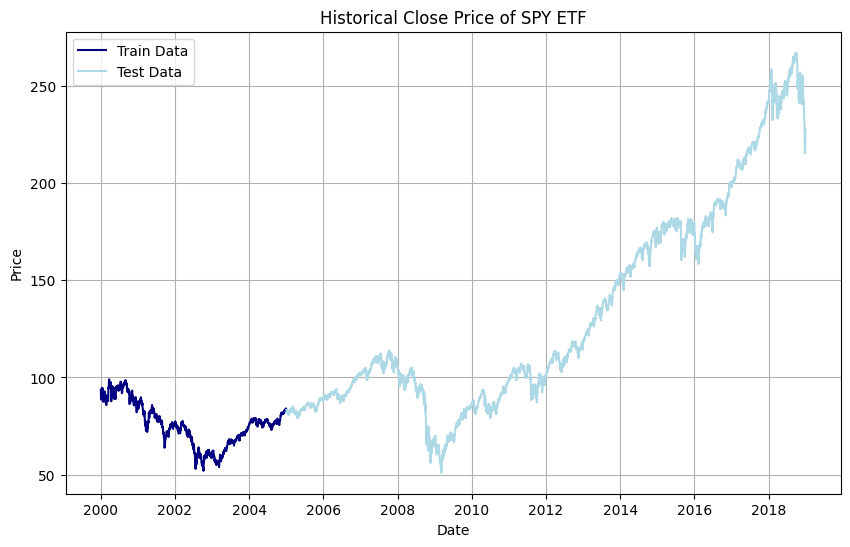

In [4]:
ticker_symbol = "SPY"

spy_data = yf.download(ticker_symbol, start="2000-01-01", end="2018-12-31")
spy_data

train_data = spy_data[spy_data.index < "2005-01-01"]
test_data = spy_data[spy_data.index >= "2005-01-01"]

train_data = train_data["Adj Close"]
test_data = test_data["Adj Close"]

plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data, label="Train Data", color="navy")
plt.plot(test_data.index, test_data, label="Test Data", color="lightblue")
plt.title("Historical Close Price of SPY ETF")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

# Environment

In [5]:
import numpy as np
import random

import gymnasium as gym
from gymnasium import spaces


class TradingEnv(gym.Env):
    def __init__(self, data, state_dim=20):
        """
        Initialize the trading environment
        """
        super(TradingEnv, self).__init__()

        self.data = data

        self.current_step = None
        self.state = None
        self.cumulative_reward = None

        self.action_space = spaces.Discrete(3)
        self.action_dic = {0: -1, 1: 0, 2: 1}  # sell  # hold  # buy

        self.observation_space = spaces.Box(
            low=np.array([0] * state_dim),
            high=np.array([np.inf] * state_dim),
            dtype=np.float32,
        )

        self.action_dim = self.action_space.n
        self.state_dim = self.observation_space.shape[0]

        self.reset()

    def reset(self):
        """
        Reset the trading environment
        """
        self.current_step = 0
        self.state = self.data.iloc[
            self.current_step : self.state_dim + self.current_step
        ]
        self.cumulative_reward = 0
        self.done = False

        return self.state

    def compute_reward(self, state, new_state, action):
        """
        Calculate the reward based on the change in balance, position, and trading action.
        """
        price = state.iloc[-1]
        new_price = new_state.iloc[-1]
        reward = (new_price - price) * action
        return reward

    def is_done(self):
        if self.state_dim + self.current_step == len(self.data):
            return True
        else:
            return False

    def step(self, action):
        """
        Take a step in the trading environment
        """
        self.current_step += 1

        # State
        state = self.state

        # New state
        new_state = self.data.iloc[
            self.current_step : self.state_dim + self.current_step
        ]

        # Reward
        reward = self.compute_reward(state, new_state, self.action_dic[action])
        self.cumulative_reward += reward

        # Done
        self.done = self.is_done()

        # Info
        self.info = {
            "step": self.current_step,
            "price": state.iloc[-1],
            "action": self.action_dic[action],
            "new_price": new_state.iloc[-1],
            "reward": self.cumulative_reward,
            "done": self.done,
        }

        self.state = new_state

        return self.state, reward, self.done, self.info

    def render(self):
        """
        Print the current state
        """
        print(f"current step: {self.current_step}")
        print(f"state: {self.state}")
        print(f"state shape: {self.state.shape}")

    def run_backtest(self, policy):
        """
        Run a full backtest of the trading environment using the provided policy.
        The policy function should take a state as input and return an action.
        """
        self.reset()
        history = []
        while not self.done:
            action = policy(self.state)
            self.step(action)
            history.append(self.info)
        return history

In [6]:
# For DQN

toy_env = TradingEnv(train_data, DQN_DEPTH)
state_1 = toy_env.state
toy_env.step(2)
state_2 = toy_env.state
assert (
    toy_env.cumulative_reward
    == (train_data.iloc[DQN_DEPTH] - train_data.iloc[DQN_DEPTH - 1]) * 1
)

toy_env = TradingEnv(train_data, DQN_DEPTH)
state_1 = toy_env.state
toy_env.step(0)
state_2 = toy_env.state
assert (
    toy_env.cumulative_reward
    == (train_data.iloc[DQN_DEPTH] - train_data.iloc[DQN_DEPTH - 1]) * -1
)

toy_env = TradingEnv(train_data, DQN_DEPTH)
state_1 = toy_env.state
toy_env.step(1)
state_2 = toy_env.state
assert (
    toy_env.cumulative_reward
    == (train_data.iloc[DQN_DEPTH] - train_data.iloc[DQN_DEPTH - 1]) * 0
)

In [7]:
# For DRQN

toy_env = TradingEnv(train_data, DRQN_DEPTH)
state_1 = toy_env.state
toy_env.step(2)
state_2 = toy_env.state
assert toy_env.cumulative_reward == (train_data.iloc[20] - train_data.iloc[19]) * 1

toy_env = TradingEnv(train_data, DRQN_DEPTH)
state_1 = toy_env.state
toy_env.step(0)
state_2 = toy_env.state
assert (
    toy_env.cumulative_reward
    == (train_data.iloc[DRQN_DEPTH] - train_data.iloc[DRQN_DEPTH - 1]) * -1
)

toy_env = TradingEnv(train_data, DRQN_DEPTH)
state_1 = toy_env.state
toy_env.step(1)
state_2 = toy_env.state
assert (
    toy_env.cumulative_reward
    == (train_data.iloc[DRQN_DEPTH] - train_data.iloc[DRQN_DEPTH - 1]) * 0
)

# Strategies

In [8]:
def eval(env, policy):

    if isinstance(policy, nn.Module):
        policy.eval()

    history = []

    total_step_count = 0
    state = torch.tensor(env.reset(), dtype=torch.float32, device=device).unsqueeze(0)

    while not env.done:
        total_step_count += 1

        action = policy(state)
        if isinstance(policy, nn.Module):
            action = action.max(1).indices.view(1, 1).item()

        next_state, _, _, _ = env.step(action)

        next_state = torch.tensor(
            next_state, dtype=torch.float32, device=device
        ).unsqueeze(0)

        state = next_state
        history.append(env.info)

    return history

In [9]:
def visualize(prices, actions):
    buy_signals = []
    sell_signals = []

    for i in range(len(prices)):
        if actions[i] == 1:
            buy_signals.append(prices[i])
            sell_signals.append(None)
        elif actions[i] == -1:
            buy_signals.append(None)
            sell_signals.append(prices[i])
        else:
            buy_signals.append(None)
            sell_signals.append(None)

    plt.figure(figsize=(15, 6))
    plt.plot(prices, color="blue", label="Price")
    plt.scatter(
        prices.index, buy_signals, color="green", label="Buy Signal", zorder=5, s=10
    )
    plt.scatter(
        prices.index, sell_signals, color="red", label="Sell Signal", zorder=5, s=10
    )
    plt.title("Price with Buy/Sell Signals")
    plt.xlabel("Time Step")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

### Buy and Hold

In [10]:
def bh_policy(state):
    """
    To reproduce the buy and hold strategy with the current environment we consider a systematic buy strategy.
    """
    return 2

### DQN

In [11]:
class DQN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dims):
        super(DQN, self).__init__()
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_dims[0])])
        for i in range(len(hidden_dims) - 1):
            self.hidden_layers.extend([nn.Linear(hidden_dims[i], hidden_dims[i + 1])])
        self.output_layer = nn.Linear(hidden_dims[-1], output_size)

    def forward(self, x):
        for layer in self.hidden_layers:
            x = F.relu(layer(x))
        x = self.output_layer(x)
        return x

In [12]:
toy_dqn = DQN(1, 3, [20, 10, 10])
toy_dqn

DQN(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=1, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
  (output_layer): Linear(in_features=10, out_features=3, bias=True)
)

### DRQN

In [13]:
class DRQN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dims, lstm_units):
        super(DRQN, self).__init__()

        self.lstm = nn.LSTM(input_size, lstm_units, batch_first=True)

        self.hidden_layers = nn.ModuleList([nn.Linear(lstm_units, hidden_dims[0])])
        for i in range(len(hidden_dims) - 1):
            self.hidden_layers.extend([nn.Linear(hidden_dims[i], hidden_dims[i + 1])])
        self.fc = nn.Linear(hidden_dims[-1], output_size)

    def forward(self, x):
        """
        x.shape: (batch_size, seq_length, input_size)
        h_0.shape: (num_layers * num_directions, batch_size, lstm_units)
        c_0.shape: (num_layers * num_directions, batch_size, lstm_units)
        """
        if len(x.shape) == 2:  # (batch_size, seq_length)
            x = x.unsqueeze(1)
        batch_size = x.size(0)

        h_0 = torch.zeros(1, batch_size, self.lstm.hidden_size)
        c_0 = torch.zeros(1, batch_size, self.lstm.hidden_size)
        x, _ = self.lstm(x, (h_0, c_0))
        for layer in self.hidden_layers:
            x = F.relu(layer(x))
        x = self.fc(x)
        x = x.squeeze(1)
        return x

In [14]:
toy_drqn = DRQN(20, 3, [20, 10, 10], 6)
toy_drqn

DRQN(
  (lstm): LSTM(20, 6, batch_first=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=6, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
  (fc): Linear(in_features=10, out_features=3, bias=True)
)

# Replay memory

In [15]:
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(
            *random.sample(self.memory, batch_size)
        )
        return np.array(state), action, reward, np.array(next_state), done

    def __len__(self):
        return len(self.memory)

# Greedy action

In [16]:
def update_epsilon(epsilon, decay_rate, min_epsilon):
    epsilon *= decay_rate
    epsilon = max(epsilon, min_epsilon)
    return epsilon


def record_explore_exploit(func):

    def wrapper(env, policy, state, epsilon):
        random_sample = np.random.rand()
        wrapper.epsilon_list.append(epsilon)
        if random_sample < epsilon:
            wrapper.action_list.append(0)
            return torch.tensor(
                [[env.action_space.sample()]], device=device, dtype=torch.long
            )
        else:
            wrapper.action_list.append(1)
            return func(policy, state)

    wrapper.action_list = []
    wrapper.epsilon_list = []

    def reset_lists():
        wrapper.action_list = []
        wrapper.epsilon_list = []

    wrapper.reset_lists = reset_lists

    return wrapper


@record_explore_exploit
def epsilon_greedy_action(policy, state):
    with torch.no_grad():
        return policy(state).max(1).indices.view(1, 1)

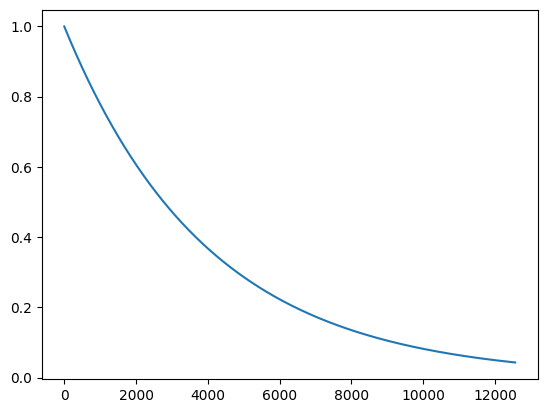

In [17]:
toy_epsilon = EPS_START
toy_epsilons = []

found_threshold = False
for i in range(len(train_data) * NUM_EPISODE):
    toy_epsilon = update_epsilon(toy_epsilon, EPS_DECAY, EPS_MIN)
    toy_epsilons.append(toy_epsilon)
    if not found_threshold and toy_epsilon == 0.01:
        print(i)
        found_threshold = True

plt.plot(toy_epsilons)
plt.show()

# Train loop

In [18]:
def train(env, model, target_model, replay_memory, optimizer, scheduler, criterion):

    model.train()

    history = []
    logs = {"action": [], "epsilon": [], "learning_rate": []}
    losses = []
    wrapper_greedy_actions = []
    wrapper_epsilons = []

    total_step_count = 0
    epsilon = EPS_START

    for episode in tqdm(range(NUM_EPISODE)):

        epoch_history = []
        epoch_losses = []

        state = torch.tensor(env.reset(), dtype=torch.float32, device=device).unsqueeze(
            0
        )

        while not env.done:
            total_step_count += 1

            logs["epsilon"].append(epsilon)
            action = epsilon_greedy_action(env, model, state, epsilon)
            logs["action"].append(env.action_dic[action.item()])
            epsilon = update_epsilon(epsilon, EPS_DECAY, EPS_MIN)

            next_state, reward, done, _ = env.step(action.item())

            next_state = torch.tensor(
                next_state, dtype=torch.float32, device=device
            ).unsqueeze(0)
            reward = torch.tensor([reward], device=device)
            replay_memory.push(state, action, reward, next_state, done)

            state = next_state

            if len(replay_memory) > BATCH_SIZE:

                states, actions, rewards, next_states, dones = replay_memory.sample(
                    BATCH_SIZE
                )
                states = torch.tensor(states, dtype=torch.float32).squeeze(1)
                # torch.Size([BATCH_SIZE, ENV_STATE_DEPTH])
                actions = torch.tensor(actions, dtype=torch.long).unsqueeze(1)
                # torch.Size([BATCH_SIZE, 1])
                rewards = torch.tensor(rewards, dtype=torch.float32)
                # torch.Size([BATCH_SIZE])
                next_states = torch.tensor(next_states, dtype=torch.float32).squeeze(1)
                # torch.Size([BATCH_SIZE, ENV_STATE_DEPTH])
                dones = torch.tensor(dones, dtype=torch.float32)
                # torch.Size([BATCH_SIZE])

                s_a_values = model(states).gather(1, actions).squeeze(-1)
                # torch.Size([BATCH_SIZE])
                next_s_values = target_model(next_states).max(dim=1).values.detach()
                # torch.Size([BATCH_SIZE])
                expected_s_a_values = rewards + (1 - dones) * GAMMA * next_s_values
                # torch.Size([BATCH_SIZE])

                loss = criterion(s_a_values, expected_s_a_values)

                logs["learning_rate"].append(optimizer.param_groups[0]["lr"])
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if (
                    total_step_count > BATCH_SIZE
                    and total_step_count % LR_DECAY_FREQ == 0
                ):
                    scheduler.step()

                epoch_losses.append(loss.item())

            if total_step_count % TARGET_UPDATE_FREQUENCY == 0:
                target_model.load_state_dict(model.state_dict())

            epoch_history.append(env.info)

        target_model.load_state_dict(model.state_dict())

        history.append(epoch_history)
        losses.append(epoch_losses)
        wrapper_epsilons.append(epsilon_greedy_action.epsilon_list)
        wrapper_greedy_actions.append(epsilon_greedy_action.action_list)

        epsilon_greedy_action.reset_lists()

    return history, logs, losses, wrapper_epsilons, wrapper_greedy_actions

# Results

### Buy and hold

In [19]:
test_env = TradingEnv(test_data, state_dim=1)
num_observations = test_env.observation_space.shape[0]
num_actions = test_env.action_space.n

bh_history = eval(test_env, bh_policy)

bh_history_df = pd.DataFrame(bh_history)
bh_history_df.head()

,step,price,action,new_price,reward,done
0,1,83.364334,1,82.345657,-1.018677,False
1,2,82.345657,1,81.777451,-1.586884,False
2,3,81.777451,1,82.193245,-1.171089,False
3,4,82.193245,1,82.075447,-1.288887,False
4,5,82.075447,1,82.463501,-0.900833,False


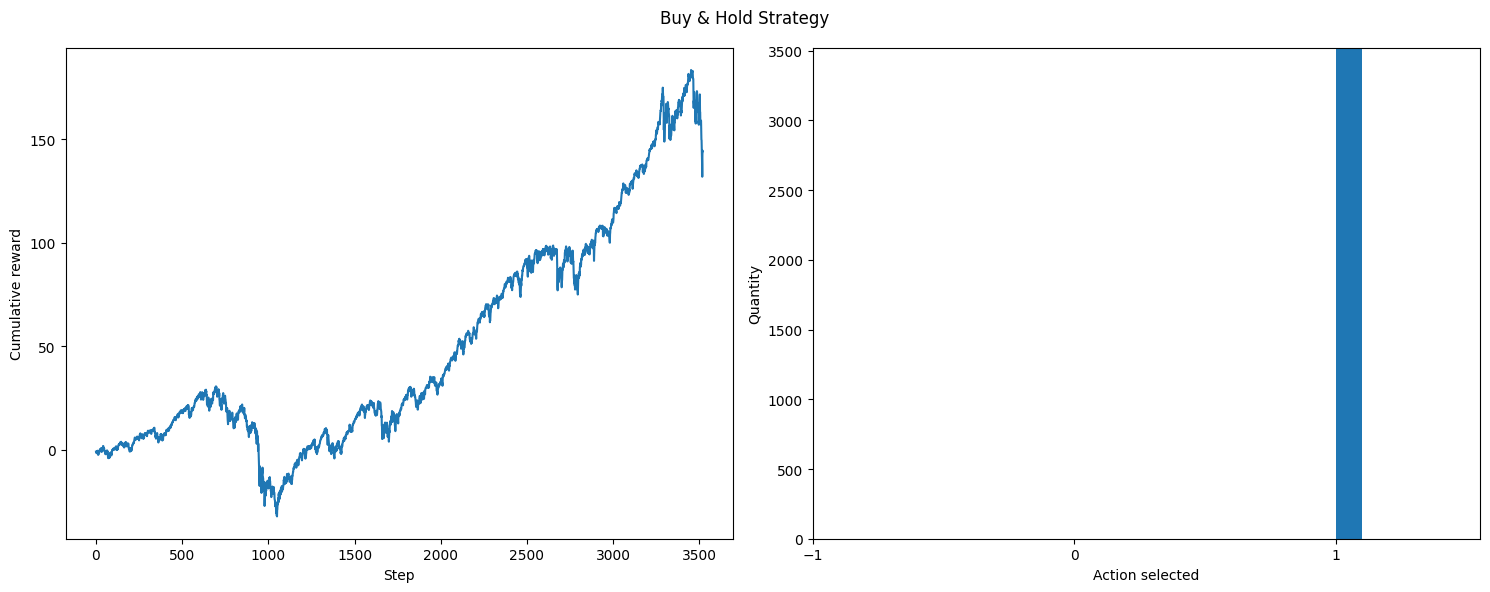

In [20]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(bh_history_df.reward)
plt.xlabel("Step")
plt.ylabel("Cumulative reward")

plt.subplot(1, 2, 2)
plt.hist(bh_history_df.action)
plt.xticks([-1, 0, 1])
plt.xlabel("Action selected")
plt.ylim(0, len(test_data))
plt.ylabel("Quantity")

plt.suptitle("Buy & Hold Strategy")
plt.tight_layout()
plt.show()

### DQN

In [ ]:
train_env = TradingEnv(train_data, state_dim=DQN_DEPTH)
num_observations = train_env.observation_space.shape[0]
num_actions = train_env.action_space.n

dqn = DQN(num_observations, num_actions, HIDDEN_DIMS).to(device)
target_dqn = DRQN(num_observations, num_actions, HIDDEN_DIMS).to(device)
target_dqn.load_state_dict(dqn.state_dict())
target_dqn.eval()

replay_memory = ReplayMemory(MEMORY_SIZE)

dqn_optimizer = torch.optim.SGD(dqn.parameters(), lr=LR)
lr_scheduler = ExponentialLR(dqn_optimizer, gamma=LR_DECAY)

criterion = nn.MSELoss()

drqn_train_history, train_logs, train_losses, wrapper_epsilons, wrapper_greedy_actions  = train(
    train_env, 
    model=dqn,
    target_model=target_dqn,
    replay_memory=replay_memory,
    optimizer=dqn_optimizer,
    scheduler=lr_scheduler,
    criterion=criterion
)

### DRQN

##### Train

In [21]:
train_env = TradingEnv(train_data, state_dim=DRQN_DEPTH)
num_observations = train_env.observation_space.shape[0]
num_actions = train_env.action_space.n

drqn = DRQN(num_observations, num_actions, HIDDEN_DIMS, NUM_RNN_UNITS).to(device)
target_drqn = DRQN(num_observations, num_actions, HIDDEN_DIMS, NUM_RNN_UNITS).to(device)
target_drqn.load_state_dict(drqn.state_dict())
target_drqn.eval()

replay_memory = ReplayMemory(MEMORY_SIZE)

drqn_optimizer = torch.optim.SGD(drqn.parameters(), lr=LR)
lr_scheduler = ExponentialLR(drqn_optimizer, gamma=LR_DECAY)

criterion = nn.MSELoss()

drqn_train_history, train_logs, train_losses, wrapper_epsilons, wrapper_greedy_actions  = train(
    train_env, 
    model=drqn,
    target_model=target_drqn,
    replay_memory=replay_memory,
    optimizer=drqn_optimizer,
    scheduler=lr_scheduler,
    criterion=criterion
)

100%|██████████| 10/10 [01:12<00:00,  7.23s/it]


##### Greedy action

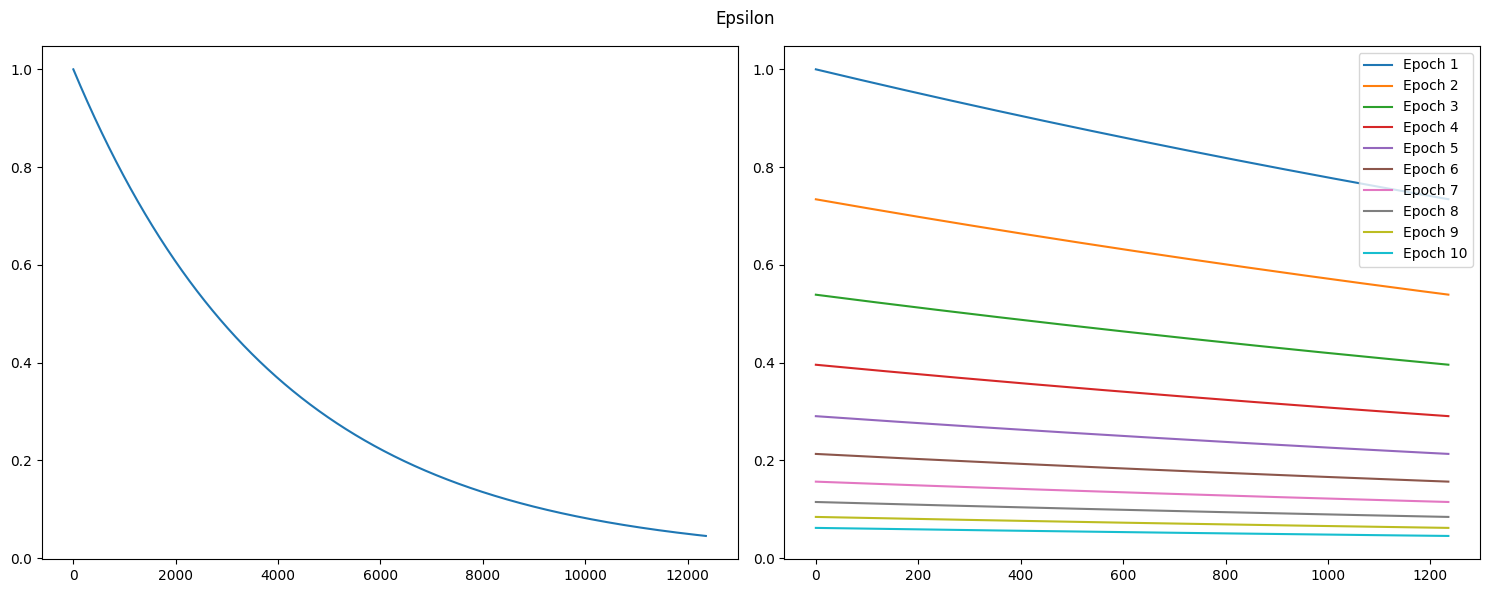

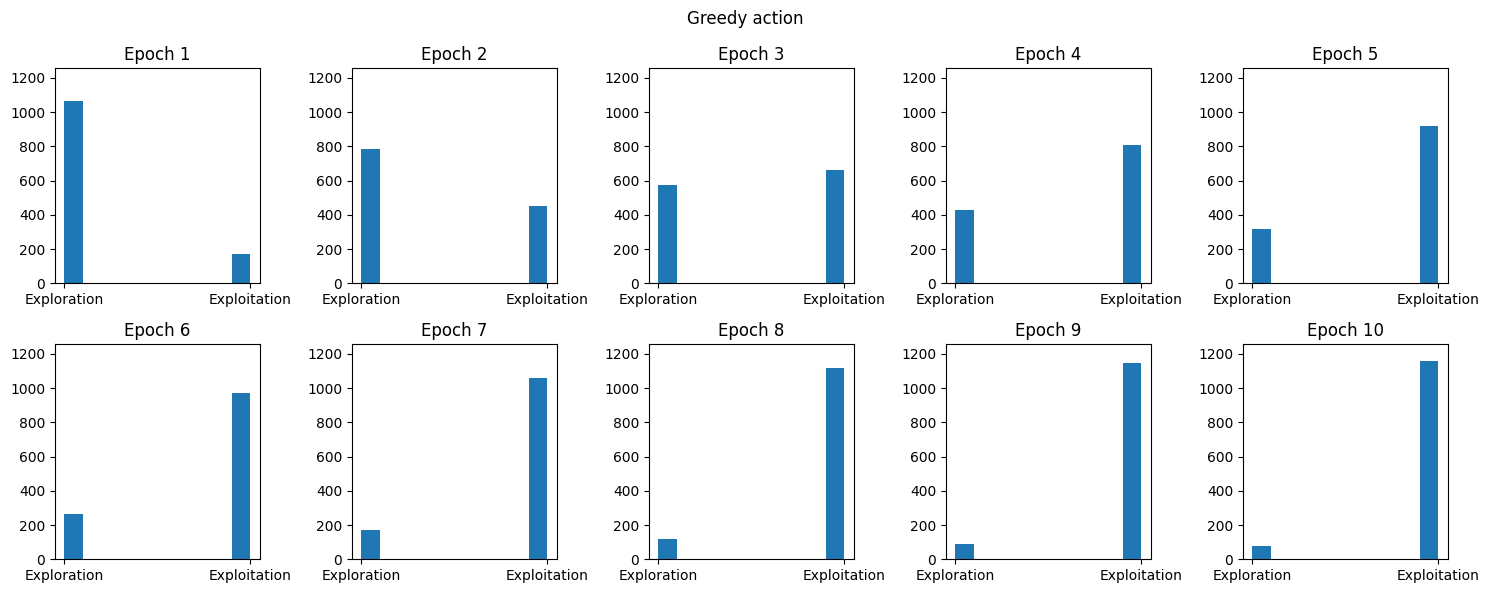

In [22]:
# Epsilon
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(train_logs["epsilon"])

plt.subplot(1, 2, 2)
for i, epsilons in enumerate(wrapper_epsilons):
    plt.plot(epsilons, label=f"Epoch {i+1}")
plt.legend()

plt.suptitle("Epsilon")
plt.tight_layout()
plt.show()

# Action
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, epoch_greedy_actions in enumerate(wrapper_greedy_actions):
    row = i // 5
    col = i % 5
    axes[row, col].hist(epoch_greedy_actions)
    axes[row, col].set_title(f"Epoch {i+1}")
    axes[row, col].set_xticks([0, 1])
    axes[row, col].set_xticklabels(["Exploration", "Exploitation"])
    axes[row, col].set_ylim(0, len(train_data))

plt.suptitle("Greedy action")
plt.tight_layout()
plt.show()

##### Action

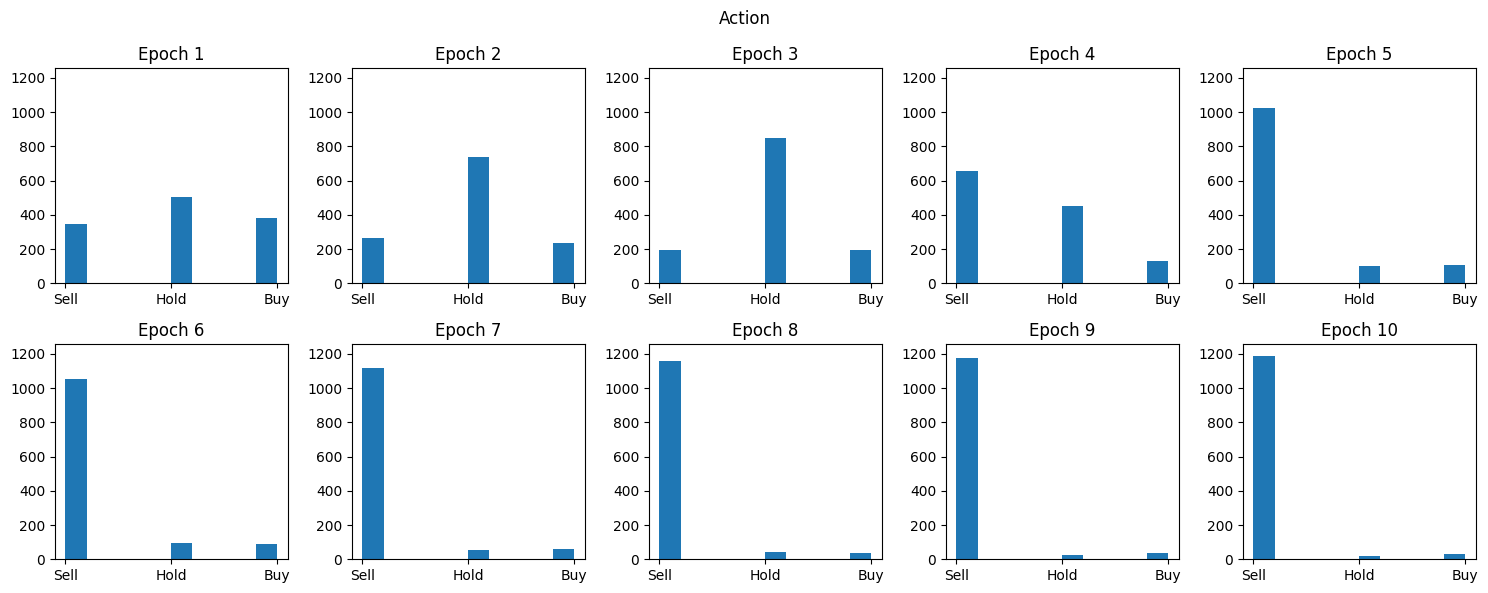

In [23]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, epoch_history in enumerate(drqn_train_history):
    row = i // 5 
    col = i % 5  
    axes[row, col].hist(pd.DataFrame(epoch_history).action)
    axes[row, col].set_title(f"Epoch {i+1}")
    axes[row, col].set_xticks([-1, 0, 1])
    axes[row, col].set_xticklabels(["Sell", "Hold", "Buy"])
    axes[row, col].set_ylim(0, len(train_data))
    
plt.suptitle("Action")
plt.tight_layout()
plt.show()

##### Loss

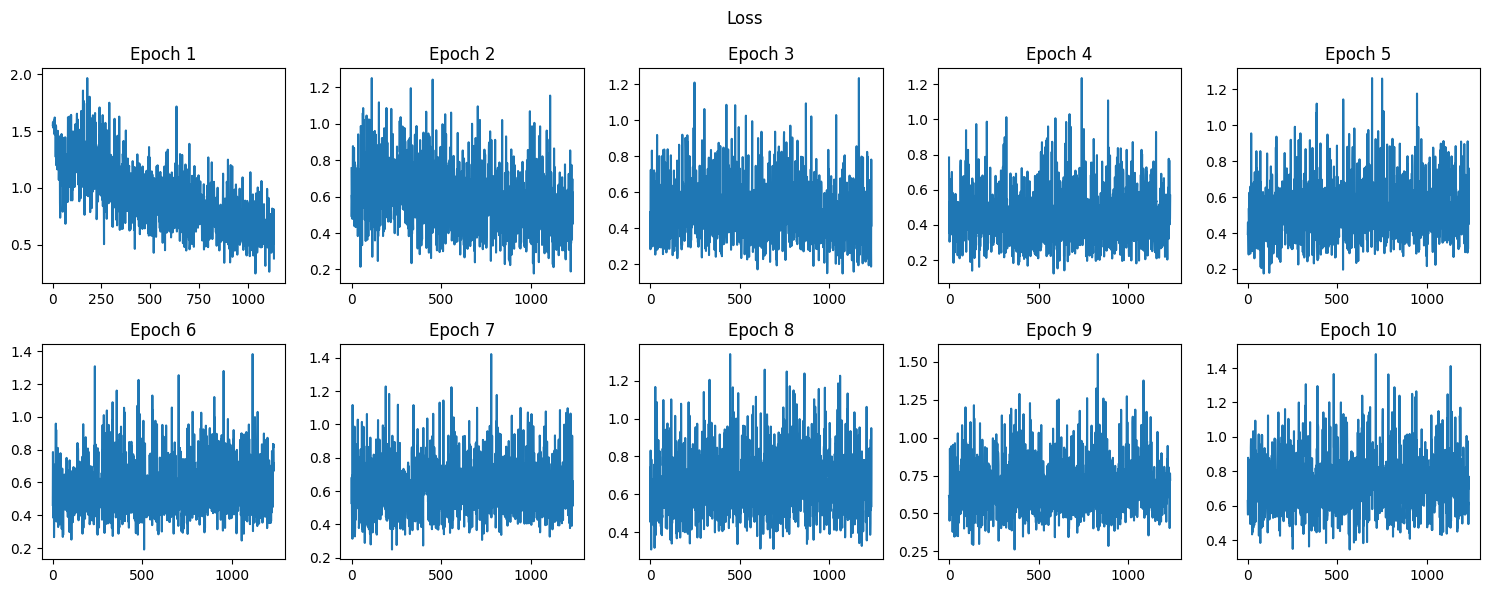

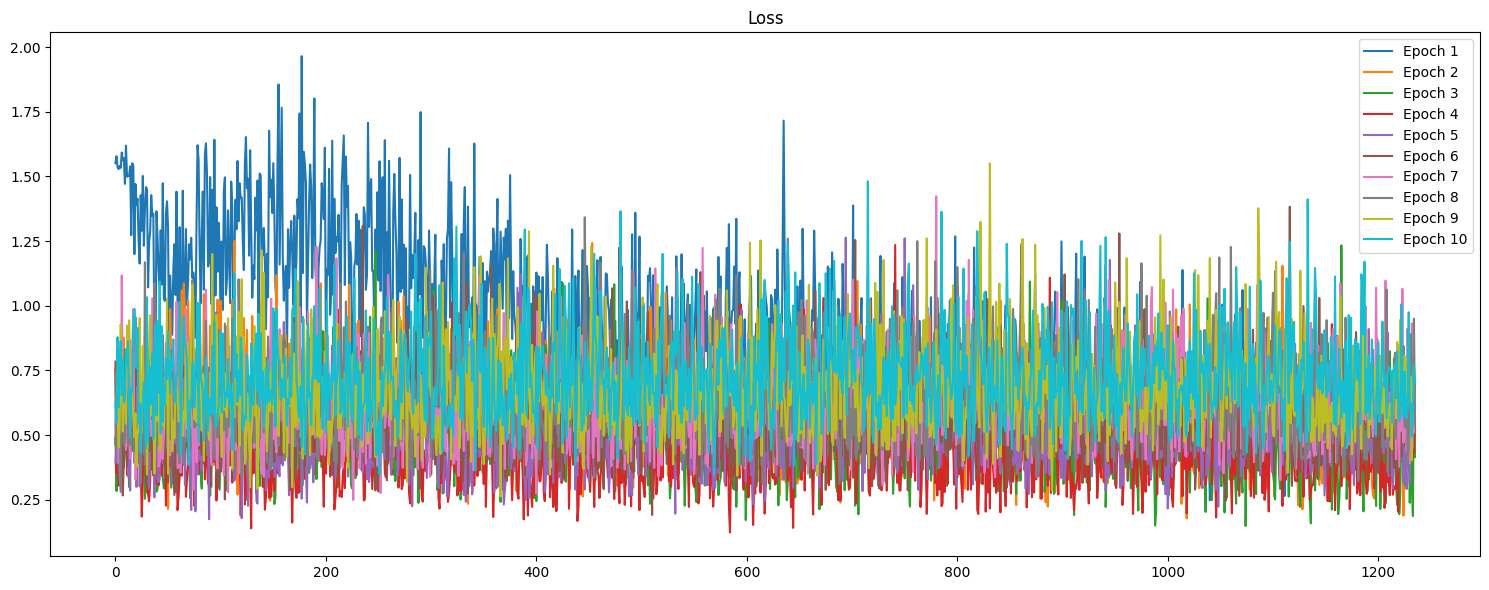

In [24]:
# Splitted
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, epoch_losses in enumerate(train_losses):
    row = i // 5 
    col = i % 5  
    axes[row, col].plot(epoch_losses)
    axes[row, col].set_title(f"Epoch {i+1}")
    
plt.suptitle("Loss")
plt.tight_layout()
plt.show()

# Stacked
plt.figure(figsize=(15, 6))

for i, epoch_losses in enumerate(train_losses):
    plt.plot(epoch_losses, label=f"Epoch {i+1}")
plt.legend()

plt.title("Loss")
plt.tight_layout()
plt.show()

##### Learning rate

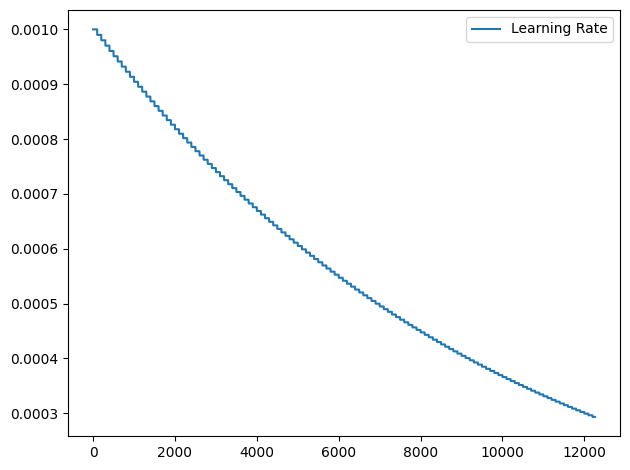

In [25]:
# plt.figure(figsize=(15, 6))
plt.plot(train_logs["learning_rate"], label="Learning Rate")
plt.legend()
plt.tight_layout()
plt.show()

##### Reward

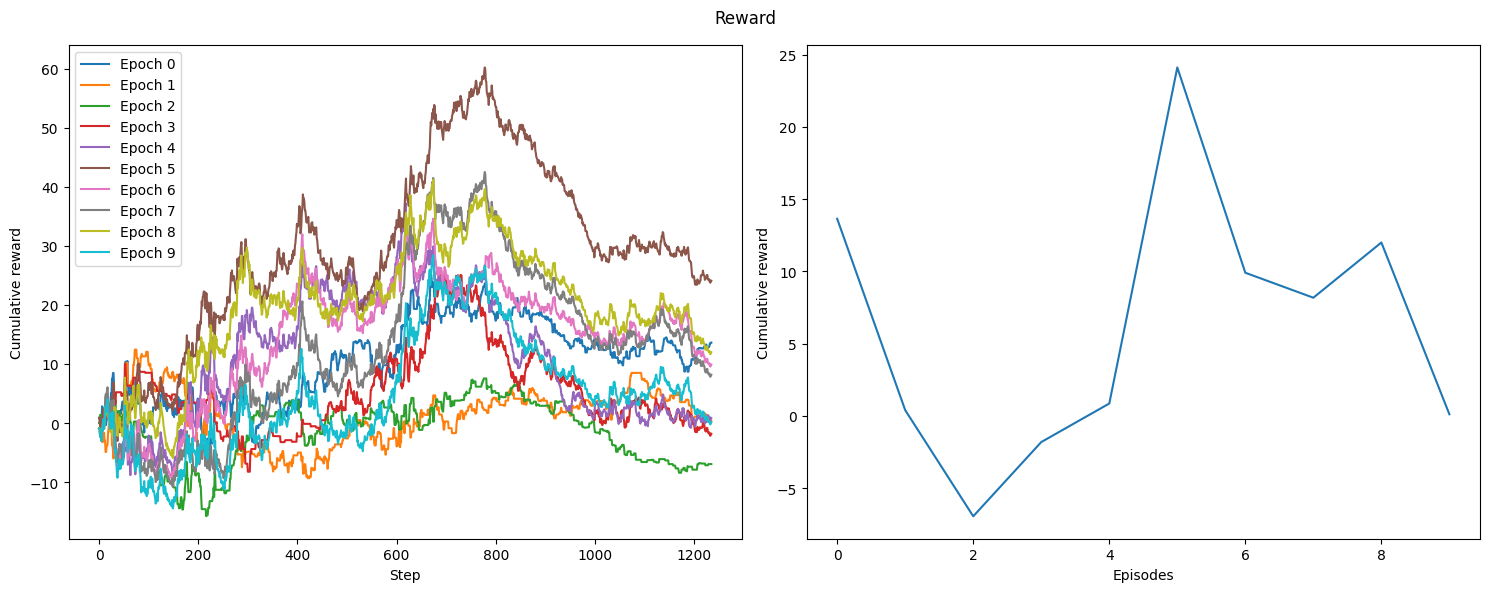

In [26]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
for i, epoch_history in enumerate(drqn_train_history):
    plt.plot(pd.DataFrame(epoch_history).reward, label=f"Epoch {i}")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Cumulative reward")

plt.subplot(1, 2, 2)
plt.plot([pd.DataFrame(epoch_history).reward.iloc[-1] for epoch_history in drqn_train_history])
plt.xlabel("Episodes")
plt.ylabel("Cumulative reward")

plt.suptitle("Reward")
plt.tight_layout()
plt.show()

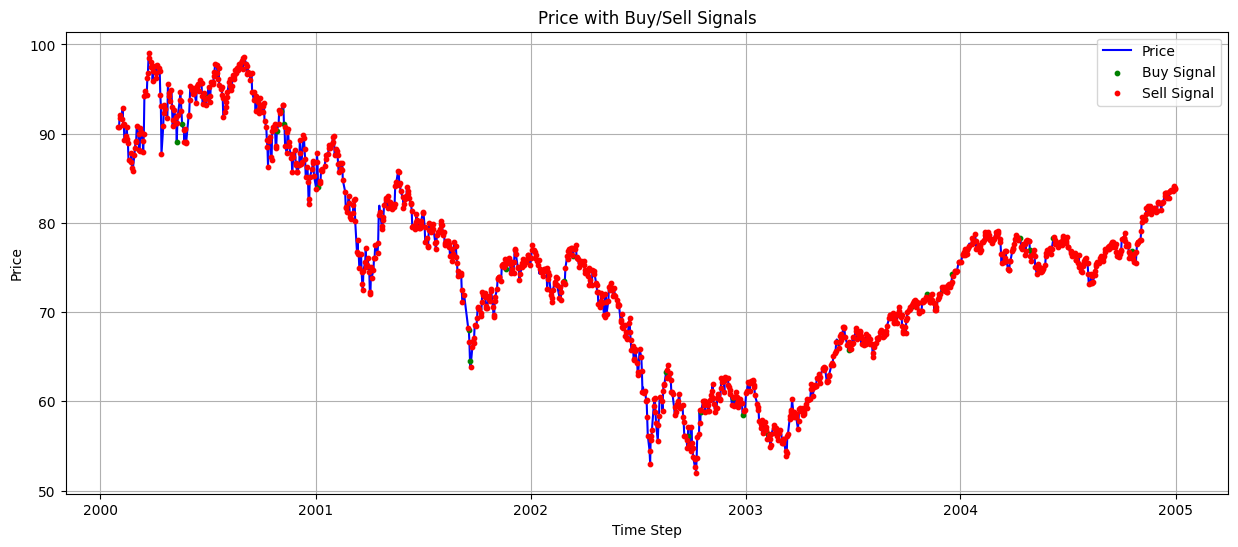

In [27]:
visualize(train_data.iloc[20:], pd.DataFrame(drqn_train_history[-1]).action)

##### Eval

In [28]:
test_env = TradingEnv(test_data, state_dim=DRQN_DEPTH)
num_observations = train_env.observation_space.shape[0]
num_actions = train_env.action_space.n

drqn_test_history = eval(test_env, policy=target_drqn)

drqn_test_history_df = pd.DataFrame(drqn_test_history)
drqn_test_history_df.head()

,step,price,action,new_price,reward,done
0,1,81.881416,-1,82.401138,-0.519722,False
1,2,82.401138,-1,82.650612,-0.769196,False
2,3,82.650612,-1,82.435776,-0.554359,False
3,4,82.435776,-1,83.315849,-1.434433,False
4,5,83.315849,-1,83.204987,-1.323570,False


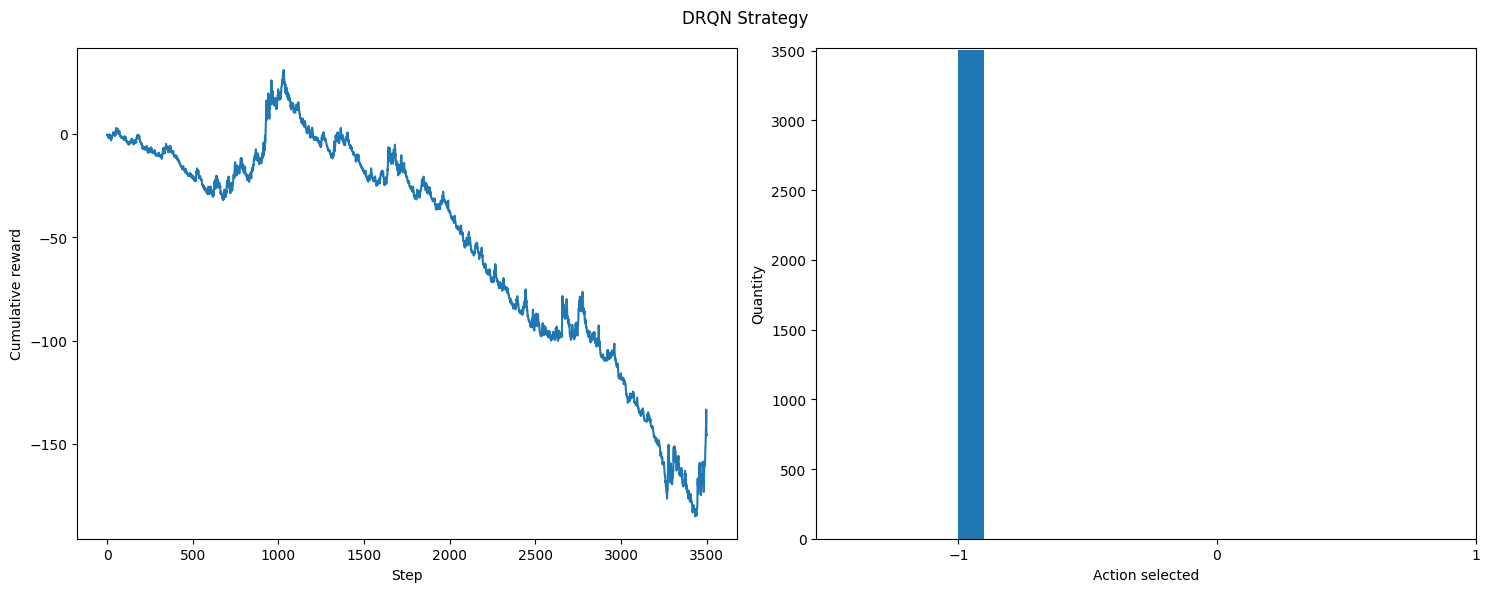

In [29]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(drqn_test_history_df.reward)
plt.xlabel("Step")
plt.ylabel("Cumulative reward")

plt.subplot(1, 2, 2)
plt.hist(drqn_test_history_df.action)
plt.xticks([-1, 0, 1])
plt.xlabel("Action selected")
plt.ylim(0, len(test_data))
plt.ylabel("Quantity")

plt.suptitle("DRQN Strategy")
plt.tight_layout()
plt.show()

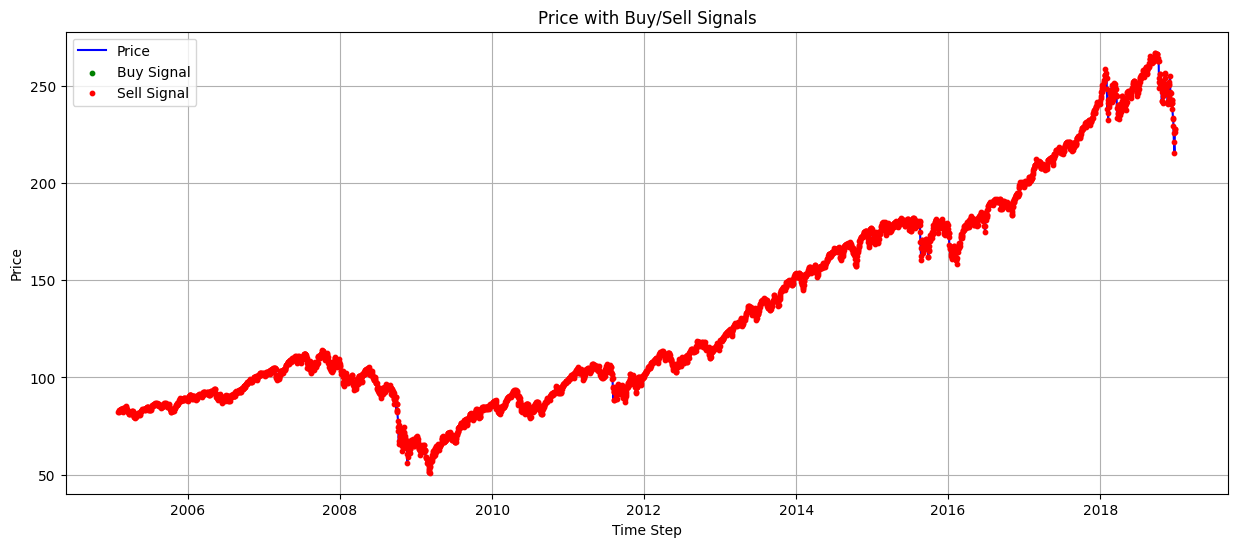

In [30]:
visualize(test_data.iloc[20:], drqn_test_history_df.action)